##Install Dependencies


In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q -U datasets
!pip install fsspec==2024.10.0
!pip install -q -U git+https://github.com/huggingface/transformers
!pip install --upgrade transformers
!pip install --upgrade bitsandbytes
!pip install --upgrade accelerate
!pip install datasets
!pip install peft

Looking in indexes: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.10.0 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 42.0 MB/s eta 0:00:00


In [ ]:
import os
import random
import functools
import csv
import re
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)

from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score,precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from google.colab import files
from google.colab import userdata
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from datasets import Dataset, DatasetDict




In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

### Environment setup


In [ ]:

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

In [ ]:
def set_all_seeds(seed):
       """Set all seeds for reproducibility"""

       random.seed(seed)
       np.random.seed(seed)
       torch.manual_seed(seed)
       if torch.cuda.is_available():
           torch.cuda.manual_seed(seed)
           torch.cuda.manual_seed_all(seed)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = False

In [ ]:
set_all_seeds(42)

In [ ]:
my_secret_key= userdata.get('HF_TOKEN')

In [ ]:
print(f"\nCUDA available: {torch.cuda.is_available()}")



CUDA available: True


##Load preprocessed dataset and make it compactable for analysis


In [ ]:
print("Please upload files for Cyber bullying detection train data")
cyb_train= files.upload()
cyb_train= next(iter(cyb_train))
cyb_train=pd.read_csv(cyb_train)

print("Please upload files for Cyber bullying detection test data")
cyb_test= files.upload()
cyb_test= next(iter(cyb_test))
cyb_test=pd.read_csv(cyb_test)

print("Please upload files for Cyber bullying detection validation data")
cyb_val= files.upload()
cyb_val= next(iter(cyb_val))
cyb_val=pd.read_csv(cyb_val)

print("Please upload files for d1")
d1_test= files.upload()
d1_test= next(iter(d1_test))
d1_test=pd.read_csv(d1_test)

print("Please upload files for d2 Agg test data")
d2_test= files.upload()
d2_test= next(iter(d2_test))
d2_test=pd.read_csv(d2_test)

print("Please upload files for d3 Agg test data")
d3_test= files.upload()
d3_test= next(iter(d3_test))
d3_test=pd.read_csv(d3_test)

print("Please upload files for d4 Agg test data")
d4_test= files.upload()
d4_test= next(iter(d4_test))
d4_test=pd.read_csv(d4_test)

print("Please upload files for d5 Agg test data")
d5_test= files.upload()
d5_test= next(iter(d5_test))
d5_test=pd.read_csv(d5_test)


Please upload files for Cyber bullying detection train data


Saving cyb_train.csv to cyb_train.csv
Please upload files for Cyber bullying detection test data


Saving cyb_test_gemma_9b.csv to cyb_test_gemma_9b.csv
Please upload files for Cyber bullying detection validation data


Saving cyb_val.csv to cyb_val.csv
Please upload files for d1


Saving d1_test.csv to d1_test.csv
Please upload files for d2 Agg test data


Saving d2_test.csv to d2_test.csv
Please upload files for d3 Agg test data


Saving d3_test.csv to d3_test.csv
Please upload files for d4 Agg test data


Saving d4_test.csv to d4_test.csv
Please upload files for d5 Agg test data


Saving d5_test.csv to d5_test.csv


In [ ]:
cyb_train = cyb_train.dropna(subset=['text']).reset_index(drop=True)
cyb_test = cyb_test.dropna(subset=['text']).reset_index(drop=True)
cyb_val = cyb_val.dropna(subset=['text']).reset_index(drop=True)
d1_test = d1_test.dropna(subset=['text']).reset_index(drop=True)
d2_test = d2_test.dropna(subset=['text']).reset_index(drop=True)
d3_test = d3_test.dropna(subset=['text']).reset_index(drop=True)
d4_test = d4_test.dropna(subset=['text']).reset_index(drop=True)
d5_test = d5_test.dropna(subset=['text']).reset_index(drop=True)

In [ ]:
# Display label distribution
cyb_train.label.value_counts()

,count
label,
age,5597
religion,5593
gender,5582
ethnicity,5576
not_cyberbullying,5564
other_cyberbullying,5470


In [ ]:
labels = id2label = ["age","religion","gender","ethnicity","not_cyberbullying","other_cyberbullying"]
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

In [ ]:
id2label

{0: 'age',
 1: 'religion',
 2: 'gender',
 3: 'ethnicity',
 4: 'not_cyberbullying',
 5: 'other_cyberbullying'}

In [ ]:
label2id

{'age': 0,
 'religion': 1,
 'gender': 2,
 'ethnicity': 3,
 'not_cyberbullying': 4,
 'other_cyberbullying': 5}

In [ ]:
cyb_train['label'] = cyb_train['label'].map(label2id)
cyb_test['label'] = cyb_test['label'].map(label2id)
cyb_val['label'] = cyb_val['label'].map(label2id)

In [ ]:
# Get minimum class count
min_count = cyb_train['label'].value_counts().min()

# Resample each class
balanced_train_dfs = [resample(cyb_train[cyb_train['label'] == lbl], replace=False, n_samples=min_count, random_state=42)
                       for lbl in cyb_train['label'].unique()]
balanced_train_df = pd.concat(balanced_train_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

# Check new label distribution
print("Balanced Label Distribution:\n", balanced_train_df['label'].value_counts())

Balanced Label Distribution:
 label
4    5470
5    5470
2    5470
1    5470
0    5470
3    5470
Name: count, dtype: int64


In [ ]:
class_weights=(1/balanced_train_df.label.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()

print(f"class weights:{class_weights}")

dataset_train = balanced_train_df
dataset_val = cyb_val

dataset = DatasetDict({
    'train': Dataset.from_pandas(dataset_train),
    'val': Dataset.from_pandas(dataset_val)
})

class weights:tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])


##Model Setup and Training


In [ ]:
model_name = "meta-llama/Llama-3.1-8B-Instruct"

In [ ]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True
)

In [ ]:
peft_config = LoraConfig(
    task_type="SEQ_CLS",
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
     target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    bias="none",
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quant_config,
    num_labels=6,
    id2label=id2label,
    label2id=label2id
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.1-8B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

In [ ]:
MAX_LEN = 512

def preprocessing_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(preprocessing_function, batched=True)
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/32820 [00:00<?, ? examples/s]

Map:   0%|          | 0/7126 [00:00<?, ? examples/s]

In [ ]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)

        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False,num_items_in_batch=None):

        labels = inputs.pop("labels").long()

        outputs = model(**inputs)

        logits = outputs.get('logits')


        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers import TrainingArguments

In [ ]:
training_args = TrainingArguments(
    output_dir='Cyber_classification',
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True
)

In [ ]:
model.base_model.config.id2label = id2label
model.base_model.config.label2id = label2id

In [ ]:
from transformers import EarlyStoppingCallback
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    class_weights=class_weights,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]

)

In [ ]:
train_result = trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009}.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: as05318 (as05318-university-of-surrey) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.344200,0.363279,0.862195,0.864559,0.862195,0.862618


##Test model with test dataset


In [ ]:
def create_augmented_text(label, text, agg_prediction=None, agg_confidence=None):
    """
    Augment text with aggression information
    """
    if agg_prediction is not None and agg_confidence is not None  and label not in(2,4):
        # Add aggression information as additional context to the text
        augmented_text = f"{text} [AGGRESSION: {agg_prediction} | CONFIDENCE: {agg_confidence:.3f}]"
    else:
        augmented_text = text

    return augmented_text

def prepare_augmented_dataset(df, has_agg_info=False):
    """
    Prepare dataset with augmented text features
    """
    df_copy = df.copy()

    if has_agg_info and 'predictions_agg' in df.columns and 'confidence_agg' in df.columns:
        print("Adding aggression information to text...")
        df_copy['text'] = df_copy.apply(
            lambda row: create_augmented_text(
                row['label'],
                row['text'],
                row['predictions_agg'],
                row['confidence_agg']
            ),
            axis=1
        )
    else:
        print("Using original text without aggression information...")

    return df_copy

In [ ]:
def make_predictions(model, df):


  sentences = df.text.tolist()

  batch_size = 32


  all_outputs = []


  for i in range(0, len(sentences), batch_size):

      batch_sentences = sentences[i:i + batch_size]

      inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)


      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])

  final_outputs = torch.cat(all_outputs, dim=0)

  probabilities = torch.softmax(final_outputs, dim=1).cpu().numpy()

  df['predictions_cyb']=final_outputs.argmax(axis=1).cpu().numpy()
  df['confidence_cyb'] = np.max(probabilities, axis=1)
  return df

In [ ]:
def evaluate_dataset(y_true, y_pred, dataset_name):
    """Evaluate model performance for a specific dataset"""
    print(f"\nResults for {dataset_name}:")

    accuracy = accuracy_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred, average='weighted')

    print(f'Accuracy: {accuracy:.3f}')
    print(f'F1 Score: {f1score:.3f}')

    target_names = labels

    report = classification_report(
        y_true,
        y_pred,
        labels=[0, 1, 2, 3, 4, 5],
        target_names=target_names
    )
    print('\nClassification Report:')
    print(report)

    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5])

    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt="d", ax=ax,
                xticklabels=target_names, yticklabels=target_names)
    ax.set_ylabel('true value')
    ax.set_xlabel('predicted value')
    plt.title('Confusion Matrix')
    plt.show()


2. Testing with aggression information:
Adding aggression information to text...

Results for With Aggression Info:
Accuracy: 0.884
F1 Score: 0.883

Classification Report:
                     precision    recall  f1-score   support

                age       0.98      0.98      0.98      1199
           religion       0.97      0.97      0.97      1198
             gender       0.92      0.88      0.90      1196
          ethnicity       0.98      0.98      0.98      1194
  not_cyberbullying       0.76      0.63      0.69      1192
other_cyberbullying       0.70      0.86      0.77      1173

           accuracy                           0.88      7152
          macro avg       0.89      0.88      0.88      7152
       weighted avg       0.89      0.88      0.88      7152



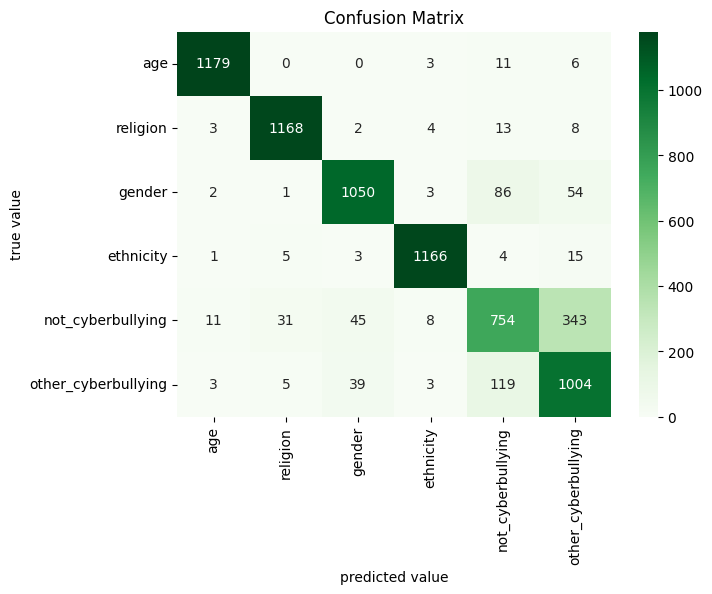

In [ ]:

print("\n2. Testing with aggression information:")
cyb_test_augmented = prepare_augmented_dataset(cyb_test, has_agg_info=True)
cyb_test_results_aug = make_predictions(model, cyb_test_augmented)
evaluate_dataset(cyb_test_results_aug['label'], cyb_test_results_aug['predictions_cyb'], 'With Aggression Info')


Results for Testing without Aggression info:
Accuracy: 0.869
F1 Score: 0.870

Classification Report:
                     precision    recall  f1-score   support

                age       0.98      0.98      0.98      1199
           religion       0.97      0.97      0.97      1198
             gender       0.91      0.88      0.89      1196
          ethnicity       0.98      0.97      0.98      1194
  not_cyberbullying       0.69      0.63      0.66      1192
other_cyberbullying       0.69      0.78      0.73      1173

           accuracy                           0.87      7152
          macro avg       0.87      0.87      0.87      7152
       weighted avg       0.87      0.87      0.87      7152



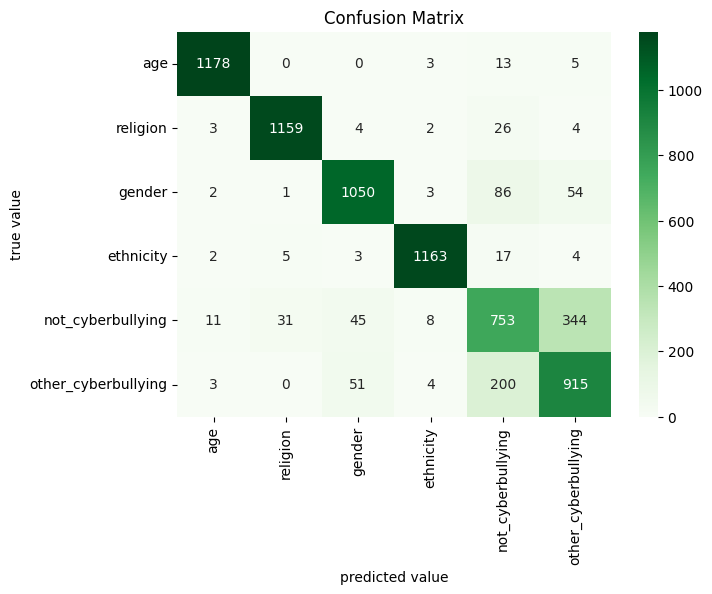

In [ ]:
model_copy=model

cyb_test_ = make_predictions(model,cyb_test)

evaluate_dataset(cyb_test['label'], cyb_test['predictions_cyb'], 'Testing without Aggression info')

##Generating cyber bullying  label for aggression test dataset for training with auxillary information

In [ ]:
d1_test_with_cyb = make_predictions(model, d1_test)

d1_test_with_cyb['predictions_cyb']=d1_test_with_cyb['predictions_cyb'].map(id2label)

d1_test_with_cyb.to_csv("d1_test_with_cyb.csv", index=False)

from google.colab import files
files.download("d1_test_with_cyb.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
d2_test_with_cyb = make_predictions(model, d2_test)

d2_test_with_cyb['predictions_cyb']=d2_test_with_cyb['predictions_cyb'].map(id2label)

d2_test_with_cyb.to_csv("d2_test_with_cyb.csv", index=False)

from google.colab import files
files.download("d2_test_with_cyb.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
d3_test_with_cyb = make_predictions(model, d3_test)

d3_test_with_cyb['predictions_cyb']=d3_test_with_cyb['predictions_cyb'].map(id2label)

d3_test_with_cyb.to_csv("d3_test_with_cyb.csv", index=False)

from google.colab import files
files.download("d3_test_with_cyb.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
d4_test_with_cyb = make_predictions(model, d4_test)

d4_test_with_cyb['predictions_cyb']=d4_test_with_cyb['predictions_cyb'].map(id2label)

d4_test_with_cyb.to_csv("d4_test_with_cyb.csv", index=False)

from google.colab import files
files.download("d4_test_with_cyb.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
d5_test_with_cyb = make_predictions(model, d5_test)

d5_test_with_cyb['predictions_cyb']=d5_test_with_cyb['predictions_cyb'].map(id2label)

d5_test_with_cyb.to_csv("d5_test_with_cyb.csv", index=False)

from google.colab import files
files.download("d5_test_with_cyb.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>